<a href="https://colab.research.google.com/github/ashishsalunkhe/Fraudulent-Review-Detection-using-CNN-LSTM-and-Word-Embeddings/blob/master/deceptive_true_review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os

# Any results you write to the current directory are saved as output.

In [4]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [5]:
df = pd.read_csv('./deceptive-opinion.csv')

In [6]:
df.head()

deceptive   hotel  polarity       source  \
0  truthful  conrad  positive  TripAdvisor   
1  truthful   hyatt  positive  TripAdvisor   
2  truthful   hyatt  positive  TripAdvisor   
3  truthful    omni  positive  TripAdvisor   
4  truthful   hyatt  positive  TripAdvisor   

                                                text  
0  We stayed for a one night getaway with family ...  
1  Triple A rate with upgrade to view room was le...  
2  This comes a little late as I'm finally catchi...  
3  The Omni Chicago really delivers on all fronts...  
4  I asked for a high floor away from the elevato...

In [7]:
df=df.sample(frac=1)

In [8]:
df.head()

deceptive             hotel  polarity       source  \
730   deceptive  intercontinental  positive        MTurk   
315    truthful           sofitel  positive  TripAdvisor   
1174   truthful  intercontinental  negative          Web   
504   deceptive          homewood  positive        MTurk   
551   deceptive     knickerbocker  positive        MTurk   

                                                   text  
730   This hotel is absolutely beautiful. I is elega...  
315   this is my new favorite place to stay in downt...  
1174  I am writing in regards to our stay April 22-2...  
504   I would first like to say how inviting the roo...  
551   We stayed at the Millennium Knickerbocker last...

In [16]:

x = df['text'].astype(str)
y = df['deceptive']

In [17]:
np.unique(df['deceptive'])

array(['deceptive', 'truthful'], dtype=object)

In [18]:
class_mapping = {label:idx for idx,label in enumerate(np.unique(df['deceptive']))}

In [19]:
class_mapping

{'deceptive': 0, 'truthful': 1}

In [20]:
df['deceptive']= df['deceptive'].map(class_mapping)

In [21]:
#pre-processing
import re 
def clean_str(string):
    """
    Tokenization/string cleaning for dataset
    Every dataset is lower cased except
    """
    string = re.sub(r"\n", "", string)    
    string = re.sub(r"\r", "", string) 
    string = re.sub(r"[0-9]", "digit", string)
    string = re.sub(r"\'", "", string)    
    string = re.sub(r"\"", "", string)    
    return string.strip().lower()
x = []
for i in range(df.shape[0]):
    x.append(clean_str(df.iloc[i][1]))
y = np.array(df["deceptive"])

In [22]:
train, test, y_train, y_test = train_test_split(x,y,stratify=y,random_state=42)

In [23]:
tokenizer = Tokenizer(num_words=None,lower=True,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',split=' ',char_level=False)
tokenizer.fit_on_texts(train)

In [24]:
x_train = tokenizer.texts_to_sequences(train)

In [25]:
x_test = tokenizer.texts_to_sequences(test)
word_index = tokenizer.word_index

In [26]:
vocab_size = len(word_index)
print('Vocab size: {}'.format(vocab_size))
longest = max(len(seq) for seq in x_train)
print("Longest comment size: {}".format(longest))
average = np.mean([len(seq) for seq in x_train])
print("Average comment size: {}".format(average))
stdev = np.std([len(seq) for seq in x_train])
print("Stdev of comment size: {}".format(stdev))
max_len = int(average + stdev * 3)
print('Max comment size: {}'.format(max_len))

Vocab size: 20
Longest comment size: 1
Average comment size: 1.0
Stdev of comment size: 0.0
Max comment size: 1


In [27]:
processed_x_train = pad_sequences(x_train, maxlen=max_len)
processed_x_test = pad_sequences(x_test, maxlen=max_len)

In [28]:
processed_post_x_train = pad_sequences(x_train, maxlen=max_len, padding='post', truncating='post')
processed_post_x_test = pad_sequences(x_test, maxlen=max_len, padding='post', truncating='post')

In [31]:
embeddings_index = {}
f = open(os.path.join('./', 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [32]:
embedding_dim = 100
k = 0
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        k += 1
        embedding_matrix[i] = embedding_vector

In [33]:
import keras.backend
from keras.models import Sequential, load_model
from keras.layers import CuDNNGRU, Dense, Conv1D, MaxPooling1D
from keras.layers import Dropout, GlobalMaxPooling1D, BatchNormalization, LSTM
from keras.layers import Bidirectional
from keras.layers.embeddings import Embedding
from keras.optimizers import Nadam
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt

In [34]:
# Initate model
model = Sequential()

# Add Embedding layer
model.add(Embedding(vocab_size + 1, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=True))

# Add Recurrent layer
#model.add(Bidirectional(CuDNNGRU(300, return_sequences=True)))
model.add(LSTM(60, return_sequences=True, name='lstm_layer'))
model.add(LSTM(30, return_sequences=True, name='lstm_layer2'))
model.add(Conv1D(filters=128, kernel_size=5, padding='same', activation='relu'))
model.add(MaxPooling1D(3))
model.add(GlobalMaxPooling1D())
model.add(BatchNormalization())

# Add fully connected layers
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

# Summarize the model
model.summary()

NotImplementedError: Cannot convert a symbolic Tensor (lstm_layer/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

In [0]:
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

In [0]:
model_hist = model.fit(processed_x_train,y_train,validation_data=(processed_x_test,y_test),epochs=10,batch_size=32,verbose=1)

Train on 1200 samples, validate on 400 samples
Epoch 1/10
1200/1200 [==============================] - 28s 24ms/step - loss: 0.5745 - acc: 0.7033 - val_loss: 0.9581 - val_acc: 0.5600
Epoch 2/10
1200/1200 [==============================] - 24s 20ms/step - loss: 0.3660 - acc: 0.8492 - val_loss: 2.6369 - val_acc: 0.5175
Epoch 3/10
1200/1200 [==============================] - 24s 20ms/step - loss: 0.2808 - acc: 0.8825 - val_loss: 0.4075 - val_acc: 0.8350
Epoch 4/10
1200/1200 [==============================] - 24s 20ms/step - loss: 0.1691 - acc: 0.9400 - val_loss: 0.4199 - val_acc: 0.8425
Epoch 5/10
1200/1200 [==============================] - 24s 20ms/step - loss: 0.1089 - acc: 0.9608 - val_loss: 3.3884 - val_acc: 0.5475
Epoch 6/10
1200/1200 [==============================] - 25s 21ms/step - loss: 0.0496 - acc: 0.9900 - val_loss: 0.4748 - val_acc: 0.8525
Epoch 7/10
1200/1200 [==============================] - 25s 21ms/step - loss: 0.0472 - acc: 0.9833 - val_loss: 0.4606 - val_acc: 0.8450
E

In [0]:
import matplotlib.pyplot as plt

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


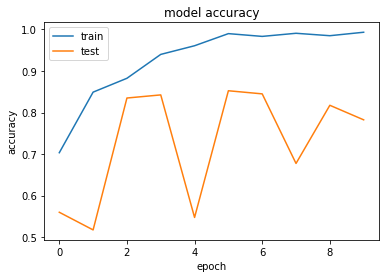

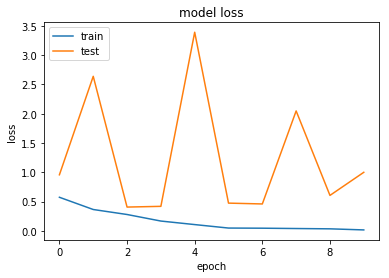

In [0]:
print(model_hist.history.keys())
# summarize history for accuracy
plt.plot(model_hist.history['acc'])
plt.plot(model_hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model_hist.history['loss'])
plt.plot(model_hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
model.save('model-2layerlstm100d-9950-8525.h5')

In [0]:
"""validation_data=([processed_x_test,processed_post_x_test],y_test),"""